In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real

import joblib

#TESS Data

In [ ]:
df = pd.read_csv('tess.csv')
display(df.info(verbose=2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7668 entries, 0 to 7667
Data columns (total 86 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   toi                7668 non-null   float64
 1   toipfx             7668 non-null   int64  
 2   tid                7668 non-null   int64  
 3   ctoi_alias         7668 non-null   float64
 4   pl_pnum            7668 non-null   int64  
 5   tfopwg_disp        7668 non-null   object 
 6   rastr              7668 non-null   object 
 7   ra                 7668 non-null   float64
 8   raerr1             0 non-null      float64
 9   raerr2             0 non-null      float64
 10  decstr             7668 non-null   object 
 11  dec                7668 non-null   float64
 12  decerr1            0 non-null      float64
 13  decerr2            0 non-null      float64
 14  st_pmra            7534 non-null   float64
 15  st_pmraerr1        7534 non-null   float64
 16  st_pmraerr2        7534 

None

In [ ]:
df['toi'].nunique(), df['tid'].nunique()

(7668, 7374)

<Axes: >

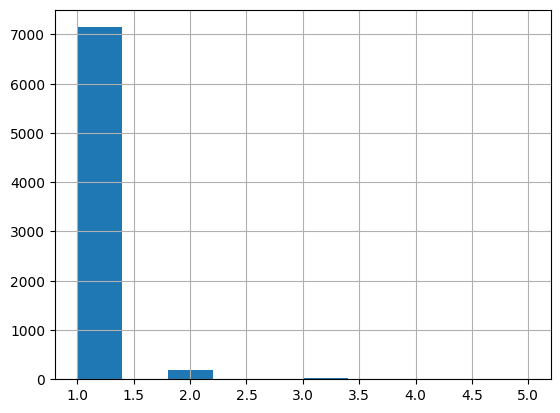

In [ ]:
df.groupby(['tid'])['toi'].count().hist()

In [ ]:
df['tfopwg_disp'].value_counts()

,count
tfopwg_disp,
PC,4675
FP,1192
CP,679
KP,565
APC,459
FA,98


In [ ]:
"""
APC=ambiguous planetary candidate
CP=confirmed planet
FA=false alarm
FP=false positive
KP=known planet
PC=planetary candidate
"""

df['tfopwg_disp'] = df['tfopwg_disp'].map({
    'APC': 'CANDIDATE',
    'CP': 'CONFIRMED',
    'FA' : 'FALSE POSITIVE',
    'FP' : 'FALSE POSITIVE',
    'KP': 'CONFIRMED',
    'PC': 'CANDIDATE',
})

df['tfopwg_disp'].value_counts()

,count
tfopwg_disp,
CANDIDATE,5134
FALSE POSITIVE,1290
CONFIRMED,1244


In [ ]:
df[['rastr', 'ra', 'decstr', 'dec']].head()

,rastr,ra,decstr,dec
0,07h29m25.85s,112.357708,-12d41m45.46s,-12.695960
1,08h10m19.31s,122.580465,-05d30m49.87s,-5.513852
2,06h58m54.47s,104.726966,-10d34m49.64s,-10.580455
3,07h22m14.39s,110.559945,-25d12m25.26s,-25.207017
4,08h08m42.77s,122.178195,-48d48m10.12s,-48.802811


In [ ]:
df[['st_pmra', 'st_pmdec']].head()

,st_pmra,st_pmdec
0,-5.964,-0.076
1,-4.956,-15.555
2,-1.462,-2.249
3,-0.939,1.640
4,-4.496,9.347


In [ ]:
for each in df.columns:
  if df[each].dtype == 'object':
    print(each)

tfopwg_disp
rastr
decstr
toi_created
rowupdate


In [ ]:
cols_req = []
for each in df.columns:
  if 'err1' not in each and 'err2' not in each and each[-3:] != 'err' and each[-3:] != 'lim':
    cols_req.append(each)

print(cols_req)

['toi', 'toipfx', 'tid', 'ctoi_alias', 'pl_pnum', 'tfopwg_disp', 'rastr', 'ra', 'decstr', 'dec', 'st_pmra', 'st_pmdec', 'pl_tranmid', 'pl_orbper', 'pl_trandurh', 'pl_trandep', 'pl_rade', 'pl_insol', 'pl_eqt', 'st_tmag', 'st_dist', 'st_teff', 'st_logg', 'st_rad', 'toi_created', 'rowupdate']


In [ ]:
id_cols = ['tid', 'toi']

num_cols = [
    'st_pmra', 'st_pmdec', 'pl_orbper', 'pl_trandurh', 'pl_trandep',
    'pl_rade', 'pl_insol', 'pl_eqt', 'st_tmag', 'st_dist',
    'st_teff', 'st_logg', 'st_rad', 'pl_pnum'
]

feat_desc = {
    'st_pmra':   "Star motion east-west",
    'st_pmdec':  "Star motion north-south",
    'pl_orbper': "Planet orbital period (days)",
    'pl_trandurh': "Transit duration (hours)",
    'pl_trandep': "Transit depth (brightness drop)",
    'pl_rade':  "Planet radius (Earth units)",
    'pl_insol': "Starlight received by planet",
    'pl_eqt':   "Planet equilibrium temperature",
    'st_tmag':  "Star brightness (TESS mag)",
    'st_dist':  "Distance to star (pc)",
    'st_teff':  "Star effective temperature (K)",
    'st_logg':  "Star surface gravity logg",
    'st_rad':   "Star radius (Sun units)",
    'pl_pnum':  "Number of planet candidates"
}

log_features = [
    'pl_orbper', 'pl_trandurh', 'pl_trandep',
    'pl_rade', 'pl_insol', 'pl_eqt',
    'st_dist', 'st_rad'
]

In [ ]:
target_col = 'tfopwg_disp'

X = df[num_cols]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.33, random_state=42)

X_train[num_cols].fillna(X_train[num_cols].median(), inplace=True)
X_val[num_cols].fillna(X_train[num_cols].median(), inplace=True)
X_test[num_cols].fillna(X_train[num_cols].median(), inplace=True)

for col in log_features:
    X_train[col] = np.log1p(X_train[col])
    X_val[col] = np.log1p(X_val[col])
    X_test[col] = np.log1p(X_test[col])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, 'tess_scaler.pkl')

['tess_scaler.pkl']

In [ ]:
medians = X_train[num_cols].median()

joblib.dump(medians, 'tess_medians.pkl')

['tess_medians.pkl']

In [ ]:
# search_space_skopt = {
#     'n_estimators': Integer(200, 1500),
#     'learning_rate': Real(0.005, 0.3, prior='log-uniform'),
#     'max_depth': Integer(3, 30),
#     'num_leaves': Integer(15, 255),
#     'min_child_samples': Integer(5, 100),
#     'min_child_weight': Real(1e-3, 10, prior='log-uniform'),
#     'subsample': Real(0.5, 1.0),
#     'subsample_freq': Integer(1, 10),
#     'colsample_bytree': Real(0.5, 1.0),
#     'reg_alpha': Real(1e-4, 10, prior='log-uniform'),
#     'reg_lambda': Real(1e-4, 10, prior='log-uniform')
# }

# bayes_search = BayesSearchCV(
#     estimator=LGBMClassifier(
#         objective='multiclass',
#         class_weight='balanced',
#         random_state=42
#     ),
#     search_spaces=search_space_skopt,
#     n_iter=50,
#     cv=5,
#     n_jobs=-1,
#     scoring='f1_macro',
#     verbose=3,
#     random_state=42
# )

# bayes_search.fit(X_train_scaled, y_train)

# params = bayes_search.best_params_
# print(f"Params: {params}")

params = {'colsample_bytree': 0.8358272823812993, 'learning_rate': 0.005088750792470964, 'max_depth': 22, 'min_child_samples': 45, 'min_child_weight': 0.00859447823403413, 'n_estimators': 1458, 'num_leaves': 82, 'reg_alpha': 0.01822576124529994, 'reg_lambda': 0.0001, 'subsample': 0.8694561822859412, 'subsample_freq': 2}

classifier = LGBMClassifier(**params, random_state=42)
model = classifier.fit(X_train_scaled, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3321
[LightGBM] [Info] Number of data points in the train set: 5367, number of used features: 14
[LightGBM] [Info] Start training from score -0.403790
[LightGBM] [Info] Start training from score -1.813800
[LightGBM] [Info] Start training from score -1.776780
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


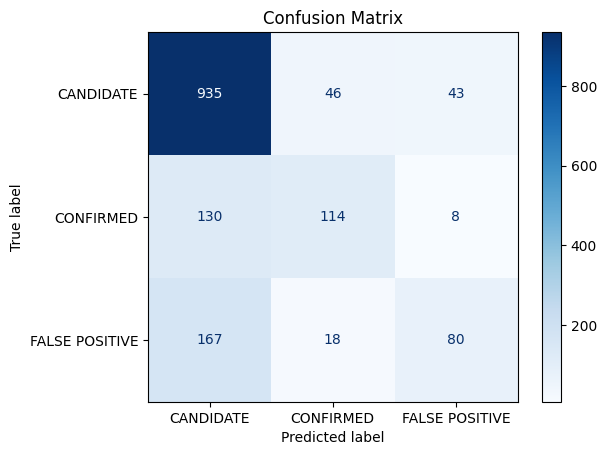

                precision    recall  f1-score   support

     CANDIDATE       0.76      0.91      0.83      1024
     CONFIRMED       0.64      0.45      0.53       252
FALSE POSITIVE       0.61      0.30      0.40       265

      accuracy                           0.73      1541
     macro avg       0.67      0.56      0.59      1541
  weighted avg       0.71      0.73      0.71      1541

0.8202835775053225 0.7999902007786577


In [ ]:
y_pred_val = model.predict(X_val_scaled)
y_pred_val_proba = model.predict_proba(X_val_scaled)

cm = confusion_matrix(y_val, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_val, y_pred_val))

auc_ovr_macro = roc_auc_score(y_val, y_pred_val_proba, multi_class="ovr", average="macro")
auc_ovr_weighted = roc_auc_score(y_val, y_pred_val_proba, multi_class="ovr", average="weighted")
print(auc_ovr_macro, auc_ovr_weighted)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


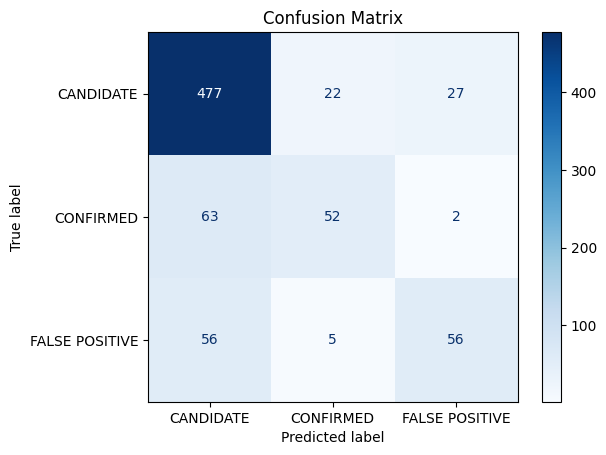

                precision    recall  f1-score   support

     CANDIDATE       0.80      0.91      0.85       526
     CONFIRMED       0.66      0.44      0.53       117
FALSE POSITIVE       0.66      0.48      0.55       117

      accuracy                           0.77       760
     macro avg       0.71      0.61      0.65       760
  weighted avg       0.76      0.77      0.76       760

0.831120920694805 0.811914854878553


In [ ]:
y_pred_test = model.predict(X_test_scaled)
y_pred_test_proba = model.predict_proba(X_test_scaled)

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred_test))

auc_ovr_macro = roc_auc_score(y_test, y_pred_test_proba, multi_class="ovr", average="macro")
auc_ovr_weighted = roc_auc_score(y_test, y_pred_test_proba, multi_class="ovr", average="weighted")
print(auc_ovr_macro, auc_ovr_weighted)

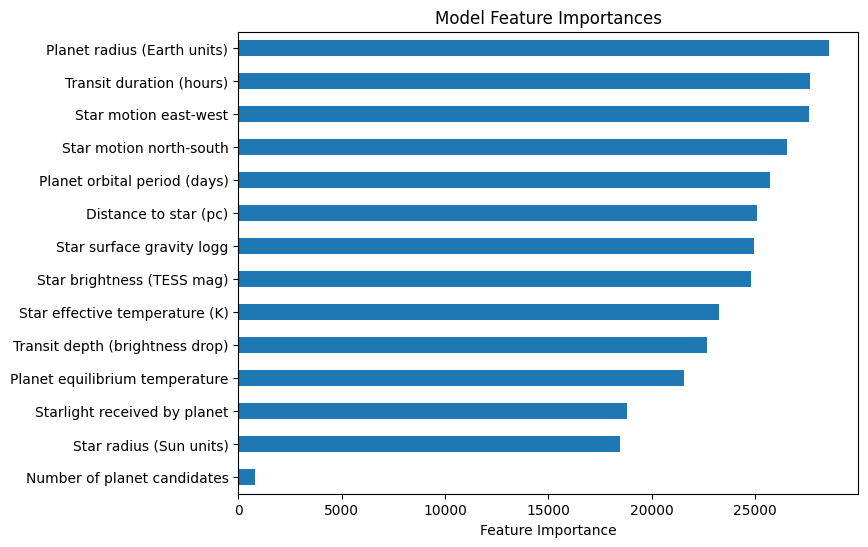

In [ ]:
feature_names = X.columns

feat_importances = pd.Series(model.feature_importances_, index=[feat_desc[each] for each in feature_names])
feat_importances = feat_importances.sort_values()

plt.figure(figsize=(8,6))
feat_importances.plot(kind="barh")
plt.xlabel("Feature Importance")
plt.title("Model Feature Importances")
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


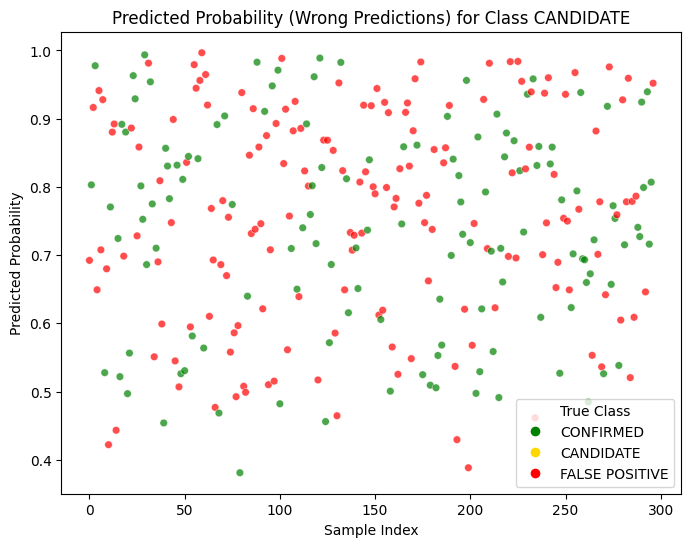

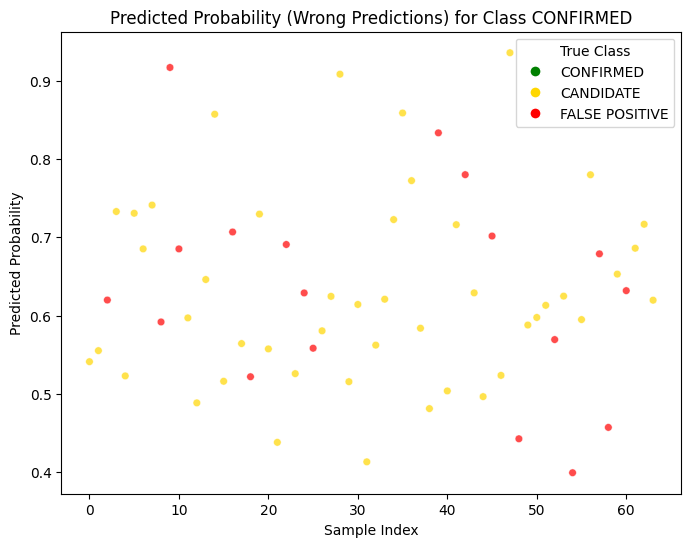

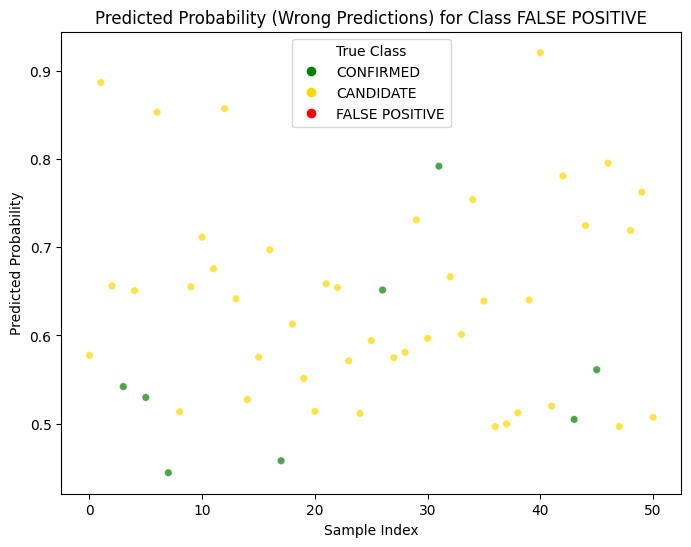

In [ ]:
y_pred_val_proba = model.predict_proba(X_val_scaled)
y_true = np.array(y_val)
palette = {
    'CONFIRMED': 'green',
    'CANDIDATE': 'gold',
    'FALSE POSITIVE': 'red'
}

for i, cls in enumerate(model.classes_):
    wrong_idx = np.where((y_pred_val != y_true) & (y_pred_val == cls))[0]
    plt.figure(figsize=(8, 6))
    class_proba = y_pred_val_proba[wrong_idx, i]
    sns.scatterplot(
        x=range(len(class_proba)),
        y=class_proba,
        hue=y_true[wrong_idx],
        palette=palette,
        legend=False,
        s=30,
        alpha=0.7
    )
    plt.title(f"Predicted Probability (Wrong Predictions) for Class {cls}")
    plt.xlabel("Sample Index")
    plt.ylabel("Predicted Probability")
    handles = [plt.Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=palette[label], markersize=8, label=label)
               for label in palette]
    plt.legend(title="True Class", handles=handles)
    plt.show()

In [ ]:
df_val = pd.DataFrame({
    'y_true': np.array(y_val),
    'y_pred': y_pred_val
})

proba_df = pd.DataFrame(
    y_pred_val_proba,
    columns=[f"proba_{cls}" for cls in model.classes_]
)

df_val = pd.concat([df_val, proba_df], axis=1)
df_val[df_val['y_true'] != df_val['y_pred']]

,y_true,y_pred,proba_CANDIDATE,proba_CONFIRMED,proba_FALSE POSITIVE
1,CANDIDATE,FALSE POSITIVE,0.390495,0.032137,0.577368
5,FALSE POSITIVE,CANDIDATE,0.692296,0.063856,0.243847
13,CONFIRMED,CANDIDATE,0.802982,0.141174,0.055844
14,FALSE POSITIVE,CANDIDATE,0.916415,0.048840,0.034745
17,CONFIRMED,CANDIDATE,0.977589,0.019361,0.003051
...,...,...,...,...,...
1531,CANDIDATE,CONFIRMED,0.299164,0.685984,0.014852
1532,CANDIDATE,CONFIRMED,0.121217,0.716603,0.162181
1534,CANDIDATE,FALSE POSITIVE,0.471864,0.020823,0.507313
1535,FALSE POSITIVE,CANDIDATE,0.951933,0.002356,0.045711


In [ ]:
import pickle

with open('tess_model.pkl', 'wb') as f:
    pickle.dump(model, f)